# BEE 4750 Homework 4: Generating Capacity Expansion

**Name**: Ella Bear

**ID**: eb739

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Documents/BEE4750/hw/hw4-eb739/hw04-eb739`


In [2]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 100 Points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

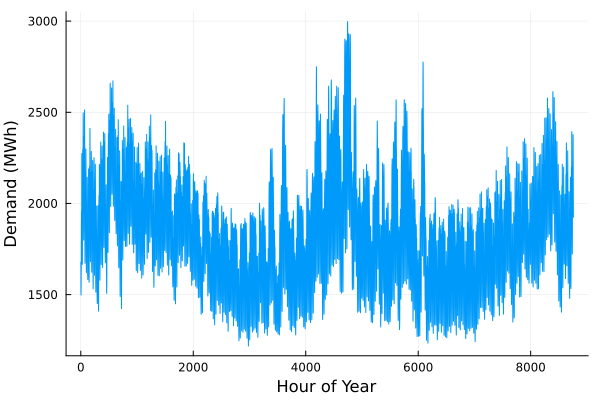

In [3]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data. This data includes fixed costs (\$/MW
installed), variable costs (\$/MWh generated), and CO<sub>2</sub>
emissions intensity (tCO<sub>2</sub>/MWh generated).

In [4]:
gens = DataFrame(CSV.File("data/generators.csv"))

Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

In [ ]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley, NY, which currently has no existing electrical
generation infrastructure. The utility can build any of the following
plant types: geothermal, coal, natural gas combined cycle gas turbine
(CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$1000/MWh.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision!

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

### Problem 1 (22 points)

Your first task is to find a capacity expansion plan which minimizes
total costs of investment and operation.

#### Problem 1.1 (2 points)

Identify and define the decision variables for the problem. Make sure to
include units.

Decision variables will be the installed capacity for each of the 6 generator types, g, $ x_{\text{g}}$ in MW and the production from each generator type g in hour t in $ y_{\text{g,t}}$ in MW. Lastly, we will have a variable for the non-energy served in MWh for a time period of hour t, $ z_{\text{t}}$


In [ ]:
using JuMP
using HiGHS

generating_model = Model(HiGHS.Optimizer)

generators = ["geothermal", "coal", "CCGT", "CT", "wind", "solar"];
time = 1:8760;
G = 1:length(generators);
T = 1:length(time);

@variable(generating_model, x[g in G]>=0);
@variable(generating_model, y[g in G,t in T]>=0);
@variable(generating_model, z[t in T]>=0);

#### Problem 1.2 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s) and define any
additional required notation beyond that introduced in Problem 1.1.

There are 6 different generator types: geothermal, coal, CCGT, CT, wind and solar. With these types and our decision variables we want to minimize the total costs for capacity expansion of type g generator. The total cost involves the cost of investment $C_{\text{INV,g}}$, cost of operation $C_{\text{OP,g}}$, and non-served energy $C_{\text{NSE,t}}$. Finally let $N_{\text{t}}$, stand for the number of hours, t. Combining all these variables the total cost is: $$\sum_{\text{g}} \text{C}_{\text{INV,g}} \times x_{\text{g}} + \sum_{\text{g}}\sum_{\text{t}} \text{N}_{\text{t}} \times C_{\text{OP,g}}\times y_{\text{g,t}} + \sum_{\text{t}} N_{\text{t}} \times \text{C}_{\text{NSE,t}} \times z_{\text{t}}$$

In [ ]:
@objective(generating_model, Min, sum([450000, 220000, 82000, 65000, 91000, 70000]' * x)
+ sum(24 * y[2,:] + 30 * y[3,:] + 40 * y[4,:]) + (1000 * sum(z)));

#### Problem 1.3 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

- Installed capacity limits for each source:
  $$0 \leq x_{\text{geothermal}}, x_{\text{coal}}, x_{\text{ccgt}}, x_{\text{ct}}, x_{\text{wind}}, x_{\text{solar}} \leq \text{Capacity Limit}$$

- Demand constraint:
  $$\sum_{\text{source}} y_{\text{source}} \geq \text{Demand}$$




In [ ]:
demand1 = demand.Demand;
production = zeros((6, 8760));

production[1, :] .= 0.85
production[2, :] .= 1
production[3, :] .= 1
production[4, :] .= 1
production[5, :] .= cap_factor.Wind
production[6, :] .= cap_factor.Solar

@constraint(generating_model, production1[g in G, t in T], y[g,t] <= production[g,t] * x[g]);
@constraint(generating_model, demand[t in T], sum(y[:, t]) .+ z[t] == demand1[t]);

#### Problem 1.4 (3 points)

Implement your optimization problem in `JuMP`.

In [ ]:
optimize!(generating_model)

#### Problem 1.5 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What will the total cost be? How much energy
will be non-served?

In [ ]:
utility_build = value.(x);
cost = objective_value(generating_model);
nonserve = sum(value.(z));

println("Utility build of each generating plant: ", join(utility_build, ", "))
println("Total cost: ", join(cost, ", "))
println("Energy of non-served: ", join(nonserve, ", "))

#### Problem 1.6 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 1.5? Do these results make sense given the generator data?

In [ ]:
# Initialize a variable to store the total annual generation
total_annual_generation = 0.0

# Loop through the elements of y and sum them
for g in G
    for t in T
        total_annual_generation += value(y[g, t])
    end
end

# Create an empty array to store the fraction of annual generation for each generator
fraction_annual_generation = zeros(length(generators))

# Calculate the fraction of annual generation for each generator
for (i, generator) in enumerate(generators)
    generator_annual_generation = sum(value.(y[i, :]))
    fraction_annual_generation[i] = generator_annual_generation / total_annual_generation
end

# Print the results
for (i, generator) in enumerate(generators)
    println("$generator Fraction of Annual Generation: ", fraction_annual_generation[i])
end

The breakdown is very similar to the breakdown of the built capacity found above. Geothermal, coal and wind have 0 annual generation which is the same as built capacity. The top two are CCGT and solar, which are the same as the built capacity, except the order is switched with built capacity. Lastly, CT has a small fraction of the annual generation which is quite similar to the built capacity. The only big difference is the amount of generation from solar and CCGT are not the same amounts and in annual generation, CCGT is larger and in built capacity solar is larger.

### Problem 2 (18 points)

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

#### Problem 2.1 (3 points)

What changes are needed to your linear program from Problem 1?
Re-formulate the problem and report it in standard form.

We need to add an emissions constraint in order to take into account the NYS legislature's annual CO2 limit. We are given emissions above, which we can make into a new array, E. We can add a constaint that the total emissions must be less than 1.5 MtCO2/yr. $$\sum_{\text{g}} \text{E}_{\text{g}} \times y_{\text{g,t}} \leq \text{Emissions Limit}$$


#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [ ]:
generating_model = Model(HiGHS.Optimizer)

generators = ["geothermal", "coal", "CCGT", "CT", "wind", "solar"];
time = 1:8760;
G = 1:length(generators);
T = 1:length(time);

@variable(generating_model, x2[g in G] >= 0);
@variable(generating_model, y2[g in G, t in T] >= 0);
@variable(generating_model, z2[t in T] >= 0);

@objective(generating_model, Min, sum([450000, 220000, 82000, 65000, 91000, 70000]' * x2)
+ sum(24 * y2[2, :] + 30 * y2[3, :] + 40 * y2[4, :]) + (1000 * sum(z2)));

demand1_new = demand1;
production = zeros((6, 8760));

production[1, :] .= 0.85
production[2, :] .= 1
production[3, :] .= 1
production[4, :] .= 1
production[5, :] .= cap_factor.Wind
production[6, :] .= cap_factor.Solar

@constraint(generating_model, production1[g in G, t in T], y2[g, t] <= production[g, t] * x2[g]);
@constraint(generating_model, demand[t in T], sum(y2[:, t]) + z2[t] == demand1_new[t]);

# CO2 emissions factors (in metric tons per MWh)
emissions_factor = [0.00 1.00 0.43 0.55 0.00 0.00];

@constraint(generating_model, co2, sum(sum(y2[:, 1:8760]) .* emissions_factor) <= 1.5 * 10^6)  # 1.5 MtCO2/yr



#### Problem 2.3 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What is different from your plan from Problem
1? Do these changes make sense?

In [ ]:
# Solve the optimization problem
optimize!(generating_model_new)

utility_build = value.(x);
cost = objective_value(generating_model_new);
nonserve = sum(value.(z));

println("Utility build of each generating plant: ", join(utility_build, ", "))
println("Total cost: ", join(cost, ", "))
println("Energy of non-served: ", join(nonserve, ", "))

The difference from plan 1, is that the geothermal, and solar are the main utility build of each generating plant. This change makes sense, as they do not have any emissions, therefore it would make sense to increase the amount of power generation from the non-emissions utility builds.

#### Problem 2.4 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 2.3? What are the differences between these results and your
plan from Problem 1?

In [ ]:
# Initialize a variable to store the total annual generation
total_annual_generation = 0.0

# Loop through the elements of y and sum them
for g in G
    for t in T
        total_annual_generation += value(y[g, t])
    end
end

# Create an empty array to store the fraction of annual generation for each generator
fraction_annual_generation = zeros(length(generators))

# Calculate the fraction of annual generation for each generator
for (i, generator) in enumerate(generators)
    generator_annual_generation = sum(value.(y[i, :]))
    fraction_annual_generation[i] = generator_annual_generation / total_annual_generation
end

# Print the results
for (i, generator) in enumerate(generators)
    println("$generator Fraction of Annual Generation: ", fraction_annual_generation[i])
end

There was an increase in the fraction of annual generation of the geothermal, it went from 0 to .678, which is an enormous increase. Furthermore, there was a decrease in CCGT fraction of annual generation and solar, and an increase in wind. Overall, the breakdowns are quite similar to 2.3, with the only difference being the utility build and fraction of annual generation of geothermal and solar not being ratioed very well.

#### Problem 2.5 (2 points)

What would the value to the utility be of allowing it to emit an
additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

In [ ]:
# Shadow price analysis for an additional 1000 tCO2/yr
# Get the shadow price for the co2 constraint
co2_price = shadow_price(co2)

# Calculate the change in profit for 
additional_co2_1000 = 1000  # Additional spruce wood (bf)
profit_change_1000 = co2_price * additional_co2_1000

# Print the shadow price and profit change
println("Shadow Price for CO2 Constraint: $co2_price")
println("Value of allowing an additional 1000 tCO2/yr: $profit_change_1000")

# Shadow price analysis for an additional 5000 tCO2/yr
# Calculate the change in profit for 
additional_co2_5000 = 5000  # Additional spruce wood (bf)
profit_change_5000 = co2_price * additional_co2_5000

# Print the shadow price and profit change
println("Value of allowing an additional 5000 tCO2/yr:  $profit_change_5000")


## References

List any external references consulted, including classmates.